# Predicting House Sale Prices

- **Dataset**: Sales from 2006-2010 in the city of Ames, Iowa, USA

- **data collection** info: [link](https://doi.org/10.1080/10691898.2011.11889627) 
The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous)

- **columns info**:[link](https://s3.amazonaws.com/dq-content/307/data_description.txt)

Using the sales data from the past we will try to establish a model that can predict the price for houses. An exemple of this project is [available](https://github.com/dataquestio/solutions/blob/master/Mission240Solutions.ipynb).

The project will be done as follow:
- data cleaning and features engineering 
- features selection
- train
- test 
- production (in the future when I know how to do that)


## Data preparation

In [374]:
import pandas as pd
pd.options.display.max_rows = 999
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split

In [375]:
#import csv
raw_sales=pd.read_csv('AmesHousing.tsv',delimiter='\t')

###### train validation test sets 60 20 20%

The validation set is used to validate the model, once a final model has been created will be tested on a test set for real measure.

In [376]:
def split_dataset(df):
    #split train test set 
    train,test_validation = train_test_split(raw_sales, test_size = 0.4, random_state = 0)

    #split test set into the validation and test set
    validation, test = train_test_split (test_validation,test_size=0.5, random_state=0)
    
    return train, validation, test

In [377]:
train, validation, test = split_dataset(raw_sales)

print(train.shape, validation.shape, test.shape)

(1758, 82) (586, 82) (586, 82)


###### General functions

In [378]:
#it will contain every transfo we do on the training set will be done also to the test and validation set
def transform_features(df):
    return train

In [379]:
def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

In [380]:
def train_and_test(df, features,target=['SalePrice']):
    
    lr= LinearRegression()
    X = df[features]
    y= df[target]
    lr.fit(X,y)
    train_predictions = lr.predict(X)
    test_predictions = lr.predict(test[features])
    
    rmse = np.sqrt(mean_squared_error(test_predictions, test[target]))
    
    print('score train set:',lr.score(X,y))
    print('score test set:', lr.score(test[features],test[target]))
    print('rmse:', rmse)
    
    return rmse

### Crude model 
For a linear regression, it needs data without gap and numeric
- let's build a model without any features enginnering to have our baseline to quantify our improvement after

In [381]:
numeric_cols = train.select_dtypes('number').columns

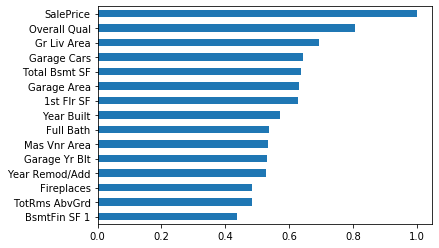

In [382]:
train[numeric_cols].corr()['SalePrice'].abs().sort_values().tail(15).plot.barh()

- In the plot below we see that overall quality feature has high correlation Overall Qual: "Rates the overall material and finish of the house"

IMO we should not use for the model has it  already leaks toward the target column the price and is not a continuous feature

- The next is Gr Liv Area : "Above grade (ground) living area square feet" so how big is the house above grand explain like 65% of the SalePrice. 

=>**Let'us this feature as our baseline model.**


In [446]:
#baseline score and rmse of our linear model 
train_and_test(train,['Gr Liv Area'])

score train set: 0.4856574021331867
score test set: 0.5583901646922056
rmse: 59093.76159983195


59093.76159983195


The results are not super good, let's see if we can improve them with some feature engineering or by adding more features
there is a correlation with the garage information so we should try to investigate a bit there

## Features Engineering (and data cleaning)
- remove any columns which:

    - has more than 5% of missing value 
    - can leak data info the price such as the year the sale took place or the overall condition 
- transform non numeric categories to something exploitable (dummy coding)
- create new features such as age house or when was it last refurbished?

In [384]:
numeric_cols

Index(['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
       'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold',
       'SalePrice'],
      dtype='object')

Text(0.5, 0, 'correlation')

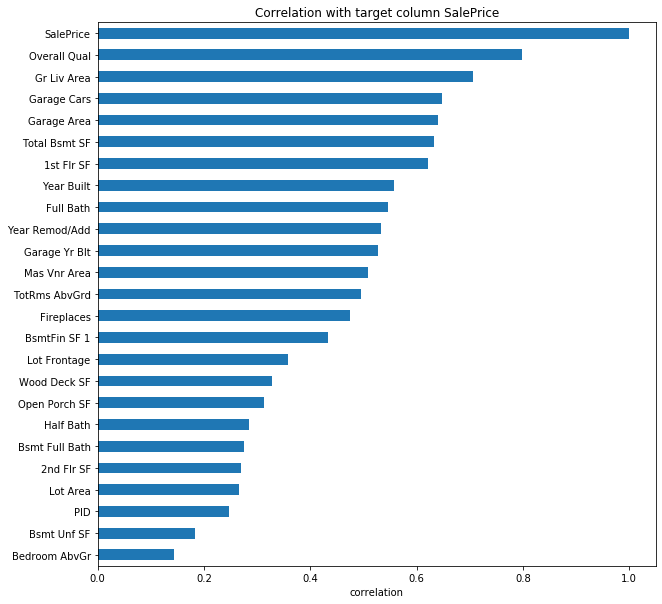

In [385]:
raw_sales[numeric_cols].corr().abs()['SalePrice'].sort_values().tail(25).plot.barh(figsize=(10,10))
plt.title('Correlation with target column SalePrice')
plt.xlabel('correlation')

## Features Engineering (and data cleaning)
We will:
- remove any columns which :
        - has more than 5% of missing value 
        - can leak data info the price such as the year the sale took place or the overall condition 
- transform non numeric categories to something exploitable (dummy coding)
- create new features such as age house or when was it last refurbished?

In [386]:
#what columns have more than 5% missing values
lot_missing_values=raw_sales.isnull().sum() / raw_sales.shape[0] 
    #list columns
col_lot_missing_values=raw_sales.columns[lot_missing_values > 0.05]
    #drop columns
raw_sales.drop(col_lot_missing_values,axis=1,inplace=True)

- among the rest of the missing value, 
    - create feature for the age of the house and how long it has been since the last modification /addition 
    - Mas Vnr  Area, 23 where there is none so we can just keep for the categorical and for the area we put 0 as it is the mode of the col.
    - Mas Vnr  Type, as we put 0 In the area it means we consider that there is no Mas Vnr so we fill up these nan with 'None'
    - Basement: the house where there are no basement: value to 'no_basement' the rest we drop (less than 5)
    
    - then let drops the rest as it is only a few rows (15 so less than 0.5% of the entier dataset)

In [387]:
raw_sales['Mas Vnr Type'].fillna('None',inplace=True)
raw_sales['Mas Vnr Area'].fillna(0,inplace=True)

raw_sales[['Bsmt Qual','Bsmt Cond']]= raw_sales[['Bsmt Qual','Bsmt Cond']].fillna('None')

#fixing basement related columns
#find the index of where there no basement => means also no exposure
index = raw_sales[raw_sales['Bsmt Qual']=='None']['Bsmt Exposure'].index
#then fix the value from 'nan' to 'no_basement'
raw_sales.loc[index,['Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2']]='None'


raw_sales.dropna(inplace=True)

#create new features
raw_sales['age_when_sold'] = raw_sales['Yr Sold'] - raw_sales['Year Built']
raw_sales['last_modif_add'] = raw_sales['Yr Sold'] - raw_sales['Year Remod/Add']

raw_sales.drop(['Year Built','Year Remod/Add'],inplace=True,axis=1)


- update the numeric cols list 

In [388]:
numeric_cols = raw_sales.select_dtypes('number').columns

- we see inthe that there are some negative values in the columns age_when_sold and last_modif_add

In [389]:
raw_sales[numeric_cols].describe()

Order           PID  MS SubClass       Lot Area  Overall Qual  \
count  2922.000000  2.922000e+03  2922.000000    2922.000000   2922.000000   
mean   1465.493155  7.143226e+08    57.424709   10136.074606      6.095483   
std     846.016295  1.887232e+08    42.671191    7860.489650      1.410864   
min       1.000000  5.263011e+08    20.000000    1300.000000      1.000000   
25%     733.250000  5.284770e+08    20.000000    7438.500000      5.000000   
50%    1464.500000  5.354532e+08    50.000000    9432.000000      6.000000   
75%    2197.750000  9.071801e+08    70.000000   11555.250000      7.000000   
max    2930.000000  1.007100e+09   190.000000  215245.000000     10.000000   

       Overall Cond  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  \
count   2922.000000   2922.000000   2922.000000   2922.000000  2922.000000   
mean       5.562971    101.145791    443.117728     49.677618   558.701574   
std        1.112149    178.777020    455.589814    169.169697   438.954197   
min        1.000000      0.000000      0.000000      0.000000     0.000000   
25%        5.000000      0.000000      0.000000      0.000000   219.000000   
50%        5.000000      0.000000    371.000000      0.000000   465.500000   
75%        6.000000    162.750000    734.750000      0.000000   801.000000   
max        9.000000   1600.000000   5644.000000   1526.000000  2336.000000   

       ...  Enclosed Porch   3Ssn Porch  Screen Porch    Pool Area  \
count  ...     2922.000000  2922.000000   2922.000000  2922.000000   
mean   ...       23.002053     2.599589     16.045859     2.249487   
std    ...       64.121675    25.175369     56.157863    35.645700   
min    ...        0.000000     0.000000      0.000000     0.000000   
25%    ...        0.000000     0.000000      0.000000     0.000000   
50%    ...        0.000000     0.000000      0.000000     0.000000   
75%    ...        0.000000     0.000000      0.000000     0.000000   
max    ...     1012.000000   508.000000    576.000000   800.000000   

           Misc Val      Mo Sold      Yr Sold      SalePrice  age_when_sold  \
count   2922.000000  2922.000000  2922.000000    2922.000000    2922.000000   
mean      50.773785     6.218344  2007.790212  180746.145791      36.461328   
std      567.113099     2.714959     1.316995   79919.670376      30.284490   
min        0.000000     1.000000  2006.000000   12789.000000      -1.000000   
25%        0.000000     4.000000  2007.000000  129500.000000       7.000000   
50%        0.000000     6.000000  2008.000000  160000.000000      34.000000   
75%        0.000000     8.000000  2009.000000  213497.500000      54.000000   
max    17000.000000    12.000000  2010.000000  755000.000000     136.000000   

       last_modif_add  
count     2922.000000  
mean        23.556810  
std         20.856785  
min         -2.000000  
25%          4.000000  
50%         15.000000  
75%         43.000000  
max         60.000000  

[8 rows x 37 columns]

In [390]:
raw_sales[raw_sales['age_when_sold']<0]['age_when_sold']

2180   -1
Name: age_when_sold, dtype: int64

In [391]:
raw_sales[raw_sales['last_modif_add']<0]['last_modif_add']

1702   -1
2180   -2
2181   -1
Name: last_modif_add, dtype: int64

In [392]:
#drop the rows where ages are negatives
raw_sales.drop(index=[2180,1702,2181],inplace=True,axis=0)

In [410]:
#reset train validation test dataset
train, validation, test = split_dataset(raw_sales)
test=pd.get_dummies(test)

#### Collinerarity with dummies

among the cols that can predict the target col, are they ones with colinearity
     -identify the col with high corr with sales price, extract these columns then recompute the correlation among them to identify colinearity

In [394]:
df_dummies=pd.get_dummies(train)

In [395]:
high_corr_cols=df_dummies.select_dtypes('number').corr().abs()['SalePrice'][df_dummies.select_dtypes('number').corr().abs()['SalePrice'] > 0.4].index.sort_values()

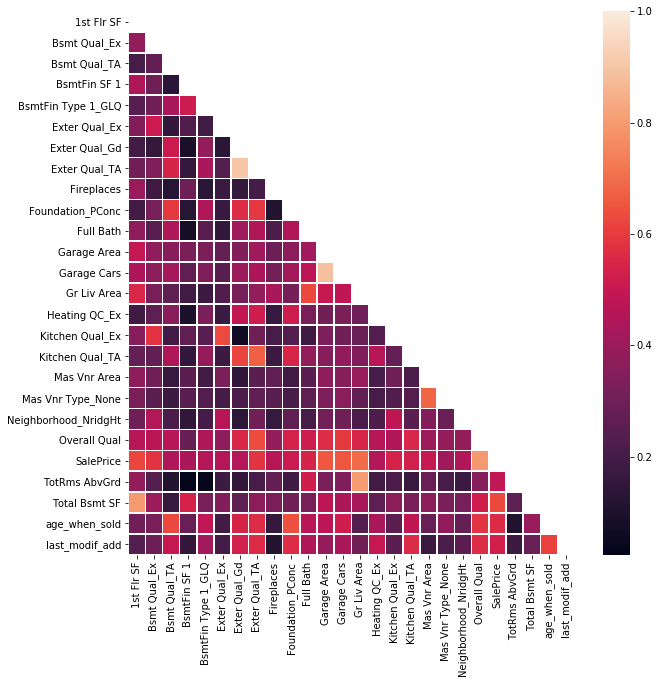

In [396]:
plt.figure(figsize=(10,10))

high_corr=df_dummies[high_corr_cols].corr().abs()
mask = np.zeros_like(high_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(high_corr,
            linewidths=.5,
            
            mask=mask)

In [427]:
#model with dummies
list_cols= df_dummies.select_dtypes('number').corr().abs()['SalePrice'][df_dummies.select_dtypes('number').corr().abs()['SalePrice'] > 0.4].sort_values(ascending=False).index
list_cols.drop('SalePrice')
list_cols = list(list_cols[1:-1])
print(list_cols)

['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'Exter Qual_TA', 'Bsmt Qual_Ex', 'age_when_sold', 'Full Bath', 'Kitchen Qual_Ex', 'Kitchen Qual_TA', 'last_modif_add', 'Foundation_PConc', 'Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces', 'Exter Qual_Ex', 'BsmtFin Type 1_GLQ', 'Exter Qual_Gd', 'Heating QC_Ex', 'Neighborhood_NridgHt', 'Bsmt Qual_TA', 'BsmtFin SF 1']


In [445]:
train_and_test(df_dummies, ['Overall Qual','Gr Liv Area', 'Total Bsmt SF', 
                            '1st Flr SF', 'Exter Qual_TA', 'Bsmt Qual_Ex', 'age_when_sold', 
                            'Full Bath', 'Kitchen Qual_Ex', 'last_modif_add', 
                            'Foundation_PConc', 'Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces', 
                            'Exter Qual_Ex', 'BsmtFin Type 1_GLQ', 'Exter Qual_Gd', 'Heating QC_Ex', 
                            'Neighborhood_NridgHt', 'Bsmt Qual_TA', 'BsmtFin SF 1'])

score train set: 0.8470726361658182
score test set: 0.8754405851834446
rmse: 31384.162715568724


31384.162715568724

In [435]:
rmses=list()
select_features=list()
for feature in list_cols:
    select_features.append(feature)
    print(select_features)
    rmse=train_and_test(df_dummies,[select_features])
    rmses.append(rmse)
    print('the rmse is ',rmse)

['Overall Qual']


KeyError: "None of [Index([('Overall Qual',)], dtype='object')] are in the [columns]"

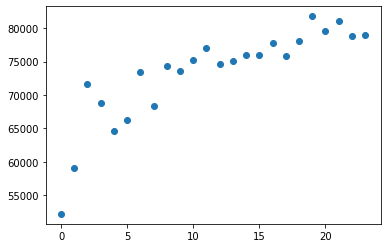

In [433]:
plt.scatter(x=range(24),y=rmses)

In [403]:
#select columns with high correlation with Sale Price
train[numeric_cols].corr().abs()['SalePrice'][train[numeric_cols].corr().abs()['SalePrice'] > 0.4].sort_values().index

Index(['BsmtFin SF 1', 'Fireplaces', 'TotRms AbvGrd', 'Mas Vnr Area',
       'last_modif_add', 'Full Bath', 'age_when_sold', '1st Flr SF',
       'Total Bsmt SF', 'Garage Cars', 'Garage Area', 'Gr Liv Area',
       'Overall Qual', 'SalePrice'],
      dtype='object')

In [442]:
#test model without dummies
a=train_and_test(train,['BsmtFin SF 1', 'Mas Vnr Area', 'Fireplaces',
       'last_modif_add', 'Full Bath', 'age_when_sold', '1st Flr SF',
       'Total Bsmt SF', 'Garage Cars'
                     ])

score train set: 0.7281266909206323
score test set: 0.7421769821518329
rmse: 45152.63616157885


In [406]:
rmses=[]
for i in range(25):
    select_features=list_cols[i]
    rmse=train_and_test(df_dummies,[select_features])
    rmses.append(rmse)

plt.plot(x=range(24))

34708.852323042986

In [407]:
rmses

[7.551454937987353e-11,
 52217.091289308795,
 59093.76159983195,
 71606.54180391354,
 68791.6108724103,
 64581.382609781685,
 66191.49878079469]

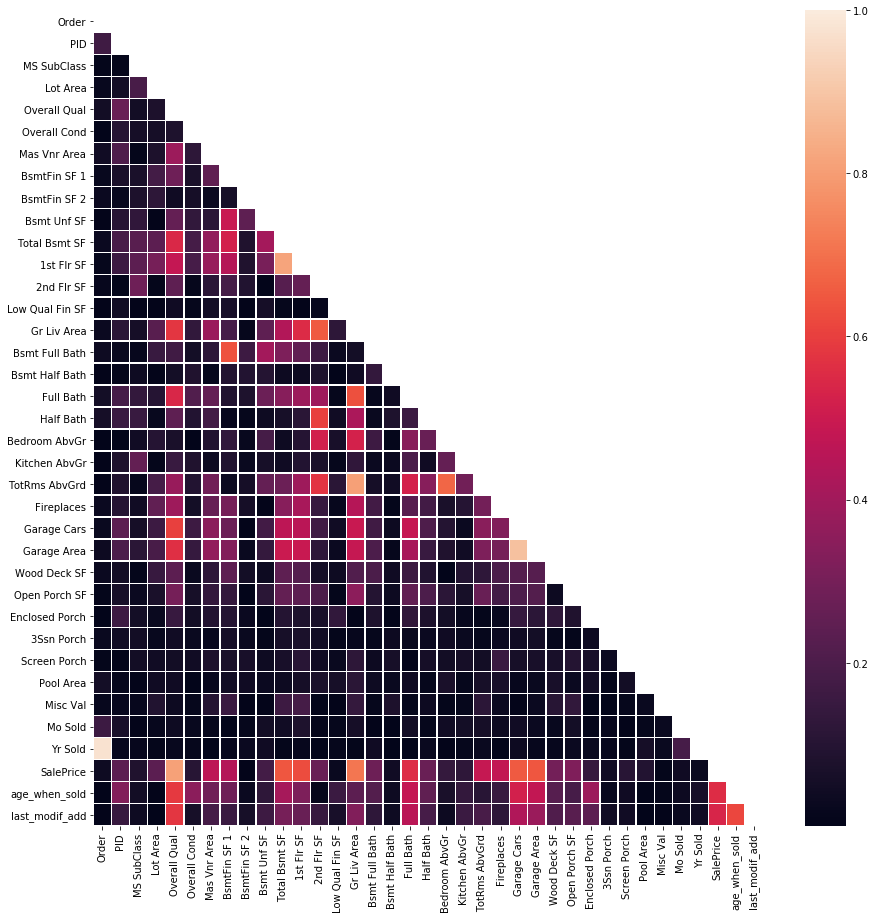

In [269]:
ax=plt.figure(figsize=(15,15))

corr=train[numeric_cols].corr().abs()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
           linewidths=.5,
           mask=mask,
           )


### Categorical features

In [436]:
#fix type for categorical columns according to the 
categorical_cols = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

- some categorical columns have been already removed

In [437]:
#['Misc Feature', 'Alley', 'Garage Type'] already not there
for col in ['Misc Feature', 'Alley', 'Garage Type']:
    categorical_cols.remove(col)

In [438]:
 raw_sales['Mas Vnr Type'].astype('category')

0         Stone
1          None
2       BrkFace
3          None
4          None
         ...   
2925       None
2926       None
2927       None
2928       None
2929    BrkFace
Name: Mas Vnr Type, Length: 2919, dtype: category
Categories (5, object): [BrkCmn, BrkFace, CBlock, None, Stone]

In [439]:
for col in categorical_cols:
    raw_sales[col] = raw_sales[col].astype('category')

In [116]:
pd.get_dummies(train).corr()['SalePrice'].sort_index

pandas.core.frame.DataFrame